In [1]:
import xml.etree.ElementTree as ET 
import numpy as np
from plotting_envir import Plotter

# Am I reading correctly?

In [2]:
def string_to_double_array(string):
    """Converts a string of doubles to an array of doubles."""
    return [float(x) for x in string.split()]

def extract_loops(data_path, file_number, start_time, which_loop):
    xmlfile = f"{data_path}/{file_number}.dat" 
    tree = ET.parse(xmlfile)  
    root = tree.getroot() 
    inline_observables = root.find("InlineObservables")
    elem = inline_observables.findall("elem")

    #Wloops of timesize t0 and t1 over all r for the file being read
    #has size num smoothings * r
    all_t0 = []
    all_t1 = []
    
    which_time = 0
    for item in elem:
        wloop = item.find("WilsonLoop")
        if wloop != None:    
            individual_t0 = [] #has size r
            individual_t1 = [] #has size r
            
            r_wilsloop2 = wloop.findall(f"wils_loop{which_loop}/wloop{which_loop}/elem/r")
            loop_wilsloop2 = wloop.findall(f"wils_loop{which_loop}/wloop{which_loop}/elem/loop")
            
            #the reading is not correct!!!!!!! 
            potential = []
            r = []
            for i, loops in enumerate(loop_wilsloop2):
                text_data = string_to_double_array(loops.text)
                individual_t0.append(text_data[start_time[which_time]])
                individual_t1.append(text_data[start_time[which_time]+1])
                r.append(int(r_wilsloop2[i].text))
            print(individual_t0)
            print("\n")
            all_t0.append(individual_t0)
            all_t1.append(individual_t1)
            
            which_time = which_time + 1
 
    if which_loop == 3:
        chunk = int(len(r)/5)
        r = np.hstack((np.linspace(1, chunk*2, chunk*2)*2**0.5, 
                      np.linspace(1, chunk, chunk)*5**0.5, 
                      np.linspace(1, chunk*2, chunk*2)*3**0.5))
        
    return np.array(r), all_t0, all_t1


In [3]:
data_path = "/home/lqcd/brian137/chroma_Wloops/gpu/data/wflow_to_0.5/data/"

In [4]:
r, t0, t1 = extract_loops(data_path, 1250, [5,5,5,5], 3)

[0.0102074874035568, 0.00118477010862983, 0.000204093300540424, 4.44345179474558e-05, 4.16623616713644e-06, 3.56749633349753e-06, -6.78349561858435e-06, 5.05361278603508e-06, -1.7727395928487e-06, 1.58936436150061e-06, -1.1444003090368e-06, 4.22418966611923e-07, -6.69726517438639e-07, -4.19121517702079e-07, -3.66048949645731e-08, 1.63203604696214e-07, -2.01457832692819e-07, 5.64100398006836e-08, 2.62433506887783e-07, -3.82179639031995e-07, 0.00263353362658971, 0.000147840549643667, 6.69554254067964e-06, -2.339724906507e-06, 2.65671929511782e-07, 9.66093081571613e-07, -1.03059563505257e-06, 1.98933805127949e-06, -2.35332835504292e-07, -5.30986773334734e-07, 0.00450735570357013, 0.000348269548391509, 3.56115520541834e-05, 4.55579804980602e-06, -8.35898141683663e-07, 7.51335201332952e-07, -1.00510721079275e-06, -1.08858093924405e-07, -1.48945515706146e-07, -2.74700613453576e-08, -1.3863299282406e-08, 2.40566076805513e-08, 8.73804544224563e-10, -3.32302139044405e-09, 1.33211919823289e-10, 

# How robust is the potential extraction over time separation?

In [5]:
def extract_loops(data_path, file_number, start_time, which_loop, set_time_diff = False, wflow_smoothing = [0,0,0,0], scale = 1):
    xmlfile = f"{data_path}/{file_number}.dat" 
    tree = ET.parse(xmlfile)  
    root = tree.getroot() 
    inline_observables = root.find("InlineObservables")
    elem = inline_observables.findall("elem")

    #Wloops of timesize t0 and t1 over all r for the file being read
    #has size num smoothings * r
    all_t0 = []
    all_t1 = []

    if set_time_diff:
        time_diff = np.int64(np.round(np.sqrt(np.array(wflow_smoothing)*8)))
        time_diff[time_diff < 1] = 1
    else:
        time_diff = np.int64(np.ones(len(wflow_smoothing))*scale)

    which_time = 0
    for item in elem:
        wloop = item.find("WilsonLoop")
        if wloop != None:    
            individual_t0 = [] #has size r
            individual_t1 = [] #has size r
            
            r_wilsloop2 = wloop.findall(f"wils_loop{which_loop}/wloop{which_loop}/elem/r")
            loop_wilsloop2 = wloop.findall(f"wils_loop{which_loop}/wloop{which_loop}/elem/loop")
            
            potential = []
            r = []
            for i, loops in enumerate(loop_wilsloop2):
                text_data = string_to_double_array(loops.text)
                individual_t0.append(text_data[start_time[which_time]])
                individual_t1.append(text_data[start_time[which_time]+time_diff[which_time]]) 
                r.append(int(r_wilsloop2[i].text))

            which_time = which_time + 1
            all_t0.append(individual_t0)
            all_t1.append(individual_t1)
 

    return np.array(r), all_t0, all_t1

In [6]:
data_path = "/home/lqcd/brian137/chroma_Wloops/gpu/data/wflow_to_0.5/data/"

In [7]:
data = [extract_loops(data_path, 1250, [5,5,5,5], 2, set_time_diff = False, scale = scale) for scale in range(1,5)]
#scale, (r, t0, t1), (wloop)

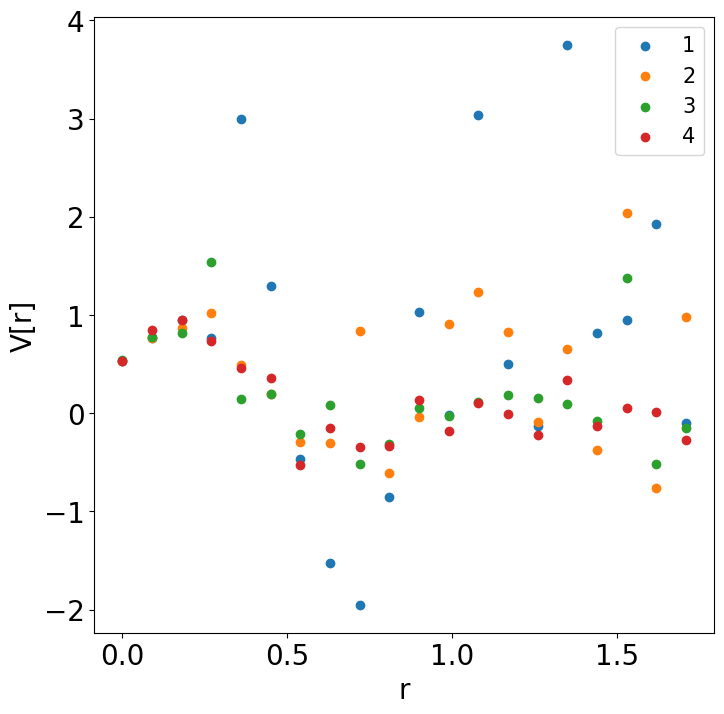

In [8]:
which_smoothing = 0
plotter = Plotter(f"", r"r", "V[r]"); ax = plotter.ax

for scale in range(1, 5):
    t0 = np.array(data[scale-1][1][which_smoothing])
    t1 = np.array(data[scale-1][2][which_smoothing])
    ax.scatter(data[scale-1][0]*0.09, np.log(abs(t0 / t1))/scale, label = scale)
plotter.show_legend()

#the noise does not seem comprehensively worse